In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy
import glob
import seaborn as sns
import pandas as pd
from scipy import signal
from numpy.fft import fft, fftshift
from scipy import stats
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming
import random
from scipy.signal import stft, windows
from sklearn.preprocessing import MinMaxScaler


In [2]:
# #Download Dataset
# !wget -r -N -c -np -v https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/

Classification
- 1=walking
- 2=descending stairs
- 3=ascending stairs
- 4=driving
- 77=clapping
- 99=non-study activity

In [3]:
# Open the participant demography csv file
demograph = pd.read_csv('participant_demog.csv')
demograph.head()

,subj_id,gender,age,height_in,weight_lbs,race,right_handed
0,idabd0c53c,male,23,72,165,caucasian,1
1,id5993bf4a,female,45,69,141,caucasian,1
2,idd80ac2b4,female,29,73,154,caucasian,1
3,id82b9735c,male,43,71,185,caucasian,1
4,id8af5374b,male,47,75,238,caucasian,1


## Sample Data : Patient 1

In [4]:
# Use the subject id to open each id's accelerometer file
pp1 = pd.read_csv('raw_accelerometry_data/'+demograph['subj_id'][0]+ '.csv')
pp1['subj_id'] = demograph['subj_id'][0]
pp1.head()

,activity,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z,subj_id
0,99,0.01,-0.004,0.949,-0.426,0.000,0.000,0.000,1.000,0.359,-0.191,0.090,0.992,-0.098,idabd0c53c
1,99,0.02,-0.477,-0.117,0.758,-0.398,-0.047,1.180,-0.055,-0.441,0.926,-0.348,0.348,0.773,idabd0c53c
2,99,0.03,-0.547,-0.637,1.016,-0.543,0.449,1.484,-0.254,-0.828,1.332,-0.336,0.676,1.078,idabd0c53c
3,99,0.04,-0.445,-0.742,0.301,-0.500,0.730,0.801,-0.195,-0.875,0.660,-0.219,0.906,0.395,idabd0c53c
4,99,0.05,-0.406,-0.801,0.000,-0.461,0.836,0.512,-0.176,-0.910,0.363,-0.172,0.977,0.098,idabd0c53c


In [5]:
# Calculate the frequency
frq = int(1/ (pp1['time_s'][1]-pp1['time_s'][0]))
print('The frequency is', frq, 'Hz')

The frequency is 100 Hz


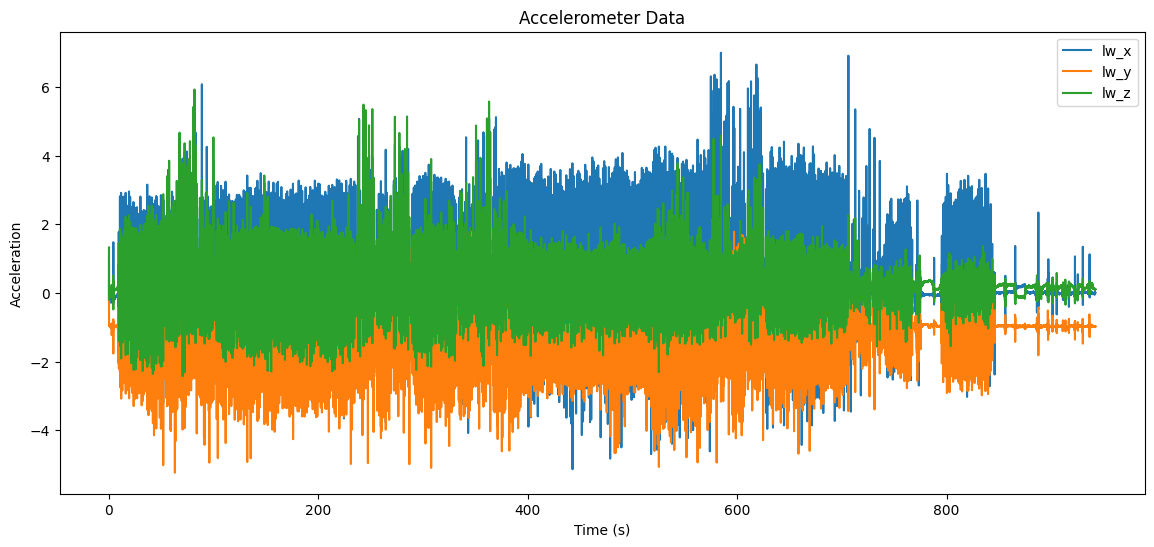

In [6]:
plt.figure(figsize=(14, 6))

plt.plot(pp1['time_s'], pp1['la_x'], label='lw_x')
plt.plot(pp1['time_s'], pp1['la_y'], label='lw_y')
plt.plot(pp1['time_s'], pp1['la_z'], label='lw_z')

plt.title('Accelerometer Data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.legend() 
plt.show()

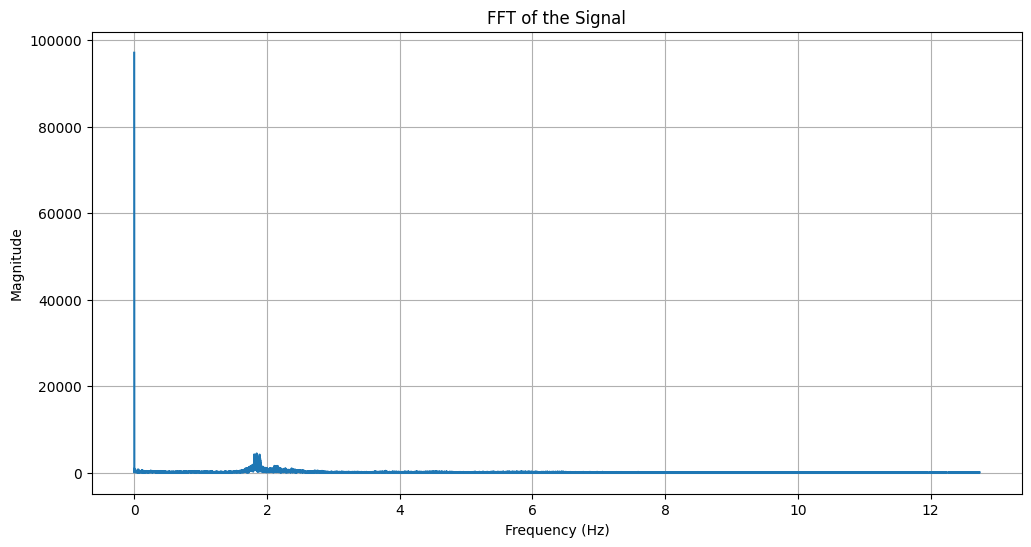

In [7]:
signal_lw = np.sqrt(pp1['lw_x']**2+pp1['lw_y']**2+pp1['lw_z']**2)
fft_values = np.fft.fft(signal_lw)
n = len(signal_lw)
frequencies = np.fft.fftfreq(n, 1/100)
magnitude = np.abs(fft_values)

plt.figure(figsize=(12, 6))
plt.plot(frequencies[0:12000], magnitude[0:12000])  # Plot only the first half of frequencies
plt.title('FFT of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


## Signal Preprocessing

Given the FFT result above, the signal needs to be filtered. Using the value give by the papers below, the FFT filter will be from 0.3 - 12.5 Hz.

-  As shown in [56], human activity frequencies are between 0 and 20 Hz, and that 98% of the FFT amplitude is contained below 10 Hz.
 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3859040/#:~:text=As%20shown%20in%20%5B56%5D%2C,is%20contained%20below%2010%20Hz.

- In essence, if we consider all relevant human movement to occur between 0.3-12.5 Hz
https://ncbi.nlm.nih.gov/pmc/articles/PMC7453603/

In [8]:
def filter(signal, fs, low_cutoff, high_cutoff):
    fft_values = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(fft_values), 1/fs)
    filter_mask = (np.abs(frequencies) >= low_cutoff) & (np.abs(frequencies) <= high_cutoff)
    fft_values[~filter_mask] = 0
    filtered_signal = np.fft.ifft(fft_values)
    return np.real(filtered_signal)

In [9]:
def filter_normalization(signal, fs, low_cutoff, high_cutoff):
    fil_lw = filter(signal, fs, low_cutoff, high_cutoff)
    n_lw = stats.zscore(fil_lw)
    return fil_lw, n_lw

In [10]:
def remove_clap(df, clap, original_length):
    df = df[df['activity'] != clap]
    num_rows_to_pad = original_length - len(df)
    pad_df = pd.DataFrame(0, index=np.arange(num_rows_to_pad), columns=df.columns) # zero padding so the same length
    padded_df = pd.concat([df, pad_df], ignore_index=True)
    return padded_df

In [11]:
filtered = True
if filtered == True:
    for index, row in demograph.iterrows():
        id = row['subj_id']
        pp = pd.read_csv('raw_accelerometry_data/'+demograph['subj_id'][0]+ '.csv')
        pp['subj_id'] = demograph['subj_id'][0]
    
        # Filter FFT and Normalization
        axes = ['lw', 'lh', 'la', 'ra']
        axis_columns = {
            'lw': ['lw_x', 'lw_y', 'lw_z'],
            'lh': ['lh_x', 'lh_y', 'lh_z'],
            'la': ['la_x', 'la_y', 'la_z'],
            'ra': ['ra_x', 'ra_y', 'ra_z']
        }
        
        fs = 100  
        low_cutoff = 0.3  
        high_cutoff = 12.5  
        filtered_df = pd.DataFrame()
    
        for axis in axes:
            combined_signal = np.sqrt(pp[axis_columns[axis][0]]**2 + pp[axis_columns[axis][1]]**2 + pp[axis_columns[axis][2]]**2)
            filt_signal, norm_signal = filter_normalization(combined_signal, fs, low_cutoff, high_cutoff)
            filtered_df[f'{axis}_filt'] = filt_signal
            filtered_df[f'{axis}_norm'] = norm_signal
    
        filtered_df['activity'] =  pp['activity']
        filtered_df = remove_clap(filtered_df, clap=77, original_length=len(pp))
        filtered_df['subj_id'] = id
    
        #Save the dataframe
        output_dir = 'filtered'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        filtered_df.to_csv(f'{output_dir}/{id}.csv', index=False)

### Sample Display Filtered Frequency

In [12]:
pf1 = pd.read_csv('filtered/'+demograph['subj_id'][0]+ '.csv')
pf1.head(3)

,lw_filt,lw_norm,lh_filt,lh_norm,la_filt,la_norm,ra_filt,ra_norm,activity,subj_id
0,0.049002,0.112445,0.025145,0.050926,0.149674,0.206643,0.024399,0.033918,99,idabd0c53c
1,0.032124,0.073715,0.344493,0.697704,0.197369,0.272492,0.034199,0.047542,99,idabd0c53c
2,0.002702,0.006201,0.595909,1.206898,0.212053,0.292765,0.037055,0.051512,99,idabd0c53c


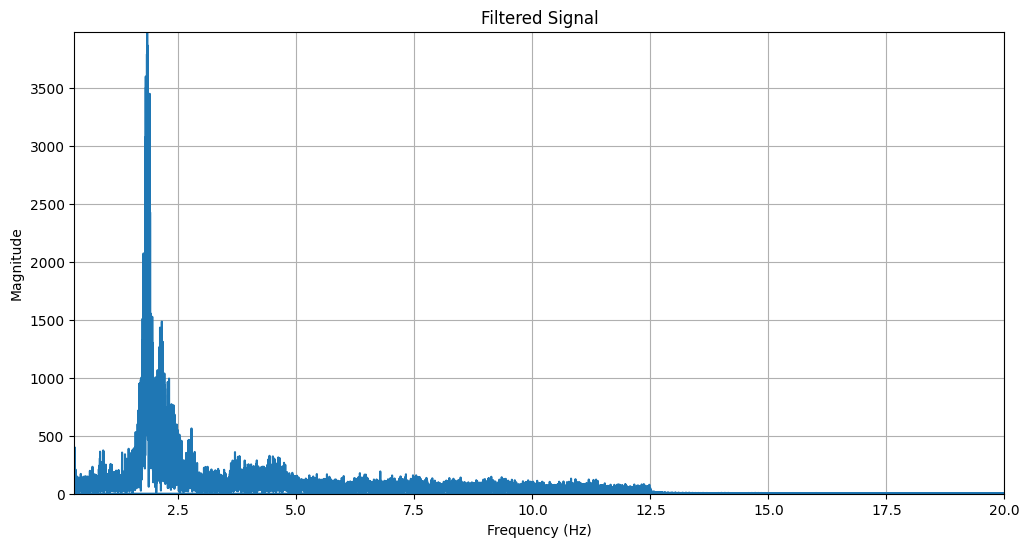

In [13]:
pf1 = pd.read_csv('filtered/'+demograph['subj_id'][0]+ '.csv')
signal_fil_lw = pf1['lw_filt']

fft_values = np.fft.fft(signal_fil_lw)
n = len(signal_fil_lw)
frequencies = np.fft.fftfreq(n, 1/100)
magnitude = np.abs(fft_values)

plt.figure(figsize=(12, 6))
plt.plot(frequencies, magnitude)  # Plot only the first half of frequencies
plt.title('Filtered Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0,max(magnitude))
plt.grid(True)
plt.xlim(0.3,20)
plt.show()

## Feature Extraction : STFT, Mean, Var, Corr

## Feature Extraction

In [21]:
def sliding_window(data, window_size, step_size):
    num_windows = (len(data) - window_size) // step_size + 1
    window_list = []
    for i in range(num_windows):
        start = i * step_size
        end = start + window_size
        window = data.iloc[start:end].copy()  # Ensure it's a copy to avoid setting with copy warning
        window_list.append(window)
    return window_list

window_size = 256 
step_size = 128 

In [22]:
def extract_features(window):
    features = {}
    
    # Define the axes and corresponding column names
    axes = ['lw', 'lh', 'la', 'ra']
    norm_columns = [f'{axis}_norm' for axis in axes]

    for axis, column in zip(axes, norm_columns):
        norm_data = window[column].values

        # Time domain features
        mean_data = np.mean(norm_data)
        features[f'Mean_{axis}'] = mean_data
        features[f'SD_{axis}'] = np.std(norm_data)

        # Frequency domain features using FFT
        fft_vals = np.abs(fft(norm_data))
        freqs = np.fft.fftfreq(len(norm_data), d=1/100)  # Assuming 100 Hz sampling rate

        # Dominant frequency
        features[f'f1_{axis}'] = freqs[np.argmax(fft_vals)]

        # Vector Magnitude Counts        
        features[f'vmc_{axis}']= np.mean(np.abs(norm_data - mean_data))

    return features

In [23]:
featured = True

window_size = 1024  
step_size = 128 

# Scale_age
scaler = MinMaxScaler()
demograph['age_norm'] = scaler.fit_transform(demograph[['age']])

if featured == True:
    for index, row in demograph.iterrows():
        id = row['subj_id']
        print(f'processing patient {id}')
        
        pp = pd.read_csv('filtered/'+demograph['subj_id'][0]+ '.csv') 
        pp['activity'] = pp['activity'].apply(lambda x: x if x in [1, 2, 3] else 0)
        
        windows_list = sliding_window(pp, window_size, step_size)

        # Extract features
        feature_list = []
        activity = []
        for window in windows_list:
            features = extract_features(window)
            feature_list.append(features)
            activity.append(window['activity'].mode()[0])  # Take the most frequent activity in that window
        
        features_df = pd.DataFrame(feature_list)
        features_df['activity'] = activity

        #Save the dataframe
        output_dir = 'featured'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        features_df.to_csv(f'{output_dir}/{id}.csv', index=False)

processing patient idabd0c53c
processing patient id5993bf4a
processing patient idd80ac2b4
processing patient id82b9735c
processing patient id8af5374b
processing patient id650857ca
processing patient idff99de96
processing patient id4ea159a8
processing patient idc91a49d0
processing patient id1c7e64ad
processing patient id8e66893c
processing patient id34e056c8
processing patient idc735fc09
processing patient id86237981
processing patient idf5e3678b
processing patient id37a54bbf
processing patient id3e3e50c7
processing patient idf1ce9a0f
processing patient idecc9265e
processing patient id687ab496
processing patient id1f372081
processing patient id079c763c
processing patient idbae5a811
processing patient id7c20ee7a
processing patient id00b70b13
processing patient id1165e00c
processing patient id5308a7d6
processing patient ida61e8ddf
processing patient id9603e9c3
processing patient idfc5f05e4
processing patient idf540d82b
processing patient idb221f542


In [17]:
# Recheck the label
aa = pd.read_csv('filtered/'+demograph['subj_id'][3]+ '.csv') 
aa['activity'].unique()

array([99,  1,  2,  3,  0], dtype=int64)